In [1]:
import os
import sys
import pickle
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
import math
from sklearn.metrics import roc_curve

sys.path.insert(0, '..')
sys.path.insert(0, '../..')
sys.path.insert(0, '../../..')
sys.path.insert(0, '../../../..')
sys.path.insert(0, '../../../../..')

from deviation_prediction.deviation import Deviation
from evaluation.deviations_evalaution_metrics import EvaluationMetrics

In [2]:
# Get results from the processed inference/ test dataset storing two dicts: 
output_dir   = '../../../../../../data/Helpdesk/conformal_prediction_gn_l4'

# Ensure the directory exists
os.makedirs(output_dir, exist_ok=True)

filename = os.path.join(output_dir, 'risk_inference_set.pkl')
with open(filename, 'rb') as f:
    loaded_results_risk = pickle.load(f)
print(f"Loaded data from {filename}")

Loaded data from ../../../../../../data/Helpdesk/conformal_prediction_gn_l4/risk_inference_set.pkl


In [3]:
# grab the list of all metric‐names from the first entry
fields_risk = list(loaded_results_risk[next(iter(loaded_results_risk))].keys())

# build the “pivoted” dict of dicts
seperate_dict_risk = {field: { prefix: subdict[field] for prefix, subdict in loaded_results_risk.items() } for field in fields_risk}

Means:  [0.80821476 0.85848852 0.82324409 0.77873289 0.73419836 0.70220673
 0.67409298 0.59059307]


SDs:  [0.11847289 0.10462908 0.08194727 0.06024027 0.0535422  0.04109202
 0.03620567 0.02899605]


Certainties:  [85.34140934 87.8124074  90.04581097 92.26432231 92.70739329 94.1481597
 94.62898022 95.09035064]


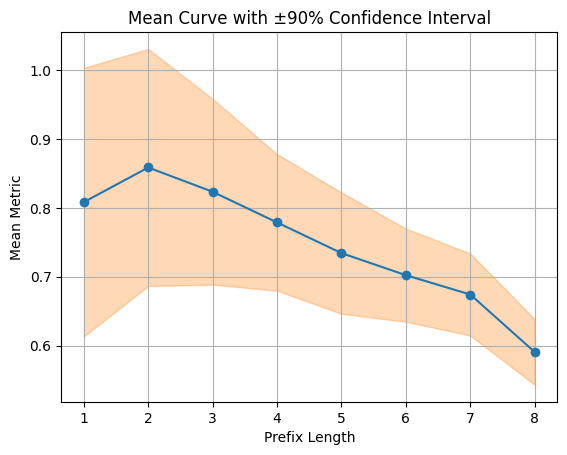

In [4]:
mean_samples_fitness_risk = seperate_dict_risk['mean_samples_fitness']
sd_samples_fitness_risk = seperate_dict_risk['sd_samples_fitness']

# Sort by prefix length
prefix = np.array(sorted(mean_samples_fitness_risk.keys()))
means  = np.array([np.mean(mean_samples_fitness_risk[k]) for k in prefix])
print("Means: ", means)
print("\n")

sds    = np.array([np.mean(sd_samples_fitness_risk[k]) for k in prefix])
print("SDs: ", sds)
print("\n")

certainty = np.array([100-(sd/mean*100) for mean, sd in zip(means, sds)])
print("Certainties: ", certainty)

# 90% CI using z ≈ 1.645
z90 = 1.645

# Std within (fitness scores of T MC-Samples)-band: Probabilistic Suffix Prediction Fitness Score standard deviation:
lower_psp = means - z90 * sds
upper_psp = means + z90* sds


plt.figure()
plt.plot(prefix, means, marker='o', label='Mean Means Samples below Threshold', color='C0')
plt.fill_between(prefix, lower_psp, upper_psp, alpha=0.3, color='C1', label='Predictive Total Uncertainty')
plt.xlabel('Prefix Length')
plt.ylabel('Mean Metric')
plt.title('Mean Curve with ±90% Confidence Interval')
plt.grid(True)
plt.show()

In [5]:
target_conformance_risk = seperate_dict_risk['target_conformance']
most_likely_conformance_risk = seperate_dict_risk['most_likely_conformance']
# dict: prefix_length: list of list where mean fitness score smaller than threshold: 1000 MC samples with: 'sampled case', 'alignment', 'cost', 'fitness' 
samples_conformance_risk = seperate_dict_risk['samples_conformance']

In [6]:
dev_obj = Deviation()

In [7]:
# dict: pref_len, dict: model_moves: list of list, with tuples containing moves, log_moves: list of list, with tuples containing moves. 
deviations_target_risk = dev_obj.individual_deviations_target(target_conformance=target_conformance_risk)

deviations_most_likely = dev_obj.individual_deviations_most_likely(most_likely_conformance=most_likely_conformance_risk)

deviations_samples_risk = dev_obj.individual_deviations_samples(samples_conformance=samples_conformance_risk, beta_threshold=0.25)

deviations_samples_risk_prob = dev_obj.individual_deviations_samples(samples_conformance=samples_conformance_risk, beta_threshold=0.25, probabilistic=True)

In [8]:
eval_obj = EvaluationMetrics(target_alignments=deviations_target_risk, predicted_alignments=deviations_samples_risk)

In [9]:
#  Measures how often the model is correct when it predicts a deviation.
precision_dev, total_weighted_pref_len_precision = eval_obj.precision_deviation()

# This measures the model's ability to detect deviations when they actually occur. -> Models prediction in relation to deviations it does not predict
recall_dev, total_weighted_pref_len_recall = eval_obj.recall_deviation()

In [10]:
# Precision nd Recall per prefix length, accumulated, and mean:

print("Precision Results:", precision_dev)
print("Total Weighted Prefix Length Precision: ", total_weighted_pref_len_precision)
print("Mean Precision Across Prefix Lengths: ", np.mean(list(precision_dev.values())))

print("\n")

print("Recall Results: ", recall_dev)
print("Total Weighted Prefix Length Recall: ", total_weighted_pref_len_recall)
print("Mean Recall Across Prefix Lengths: ", np.mean(list(recall_dev.values())))

Precision Results: OrderedDict({1: 0.375, 2: 0.7391304347826086, 3: 0.8044692737430168, 4: 0.8974358974358975, 5: 0.9117647058823529, 6: 0.8620689655172413, 7: 0.9285714285714286, 8: 0.6666666666666666})
Total Weighted Prefix Length Precision:  0.79296875
Mean Precision Across Prefix Lengths:  0.7731384215749015


Recall Results:  OrderedDict({1: 0.09545454545454546, 2: 0.15454545454545454, 3: 0.6857142857142857, 4: 0.875, 5: 0.8493150684931506, 6: 0.8333333333333334, 7: 0.8666666666666667, 8: 0.6666666666666666})
Total Weighted Prefix Length Recall:  0.4556677890011223
Mean Recall Across Prefix Lengths:  0.6283370026092628


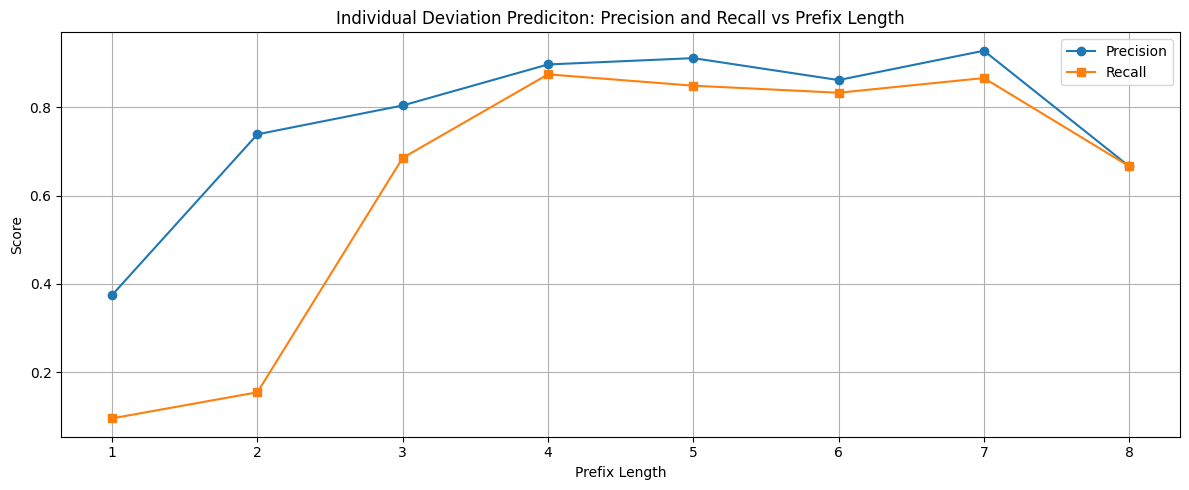

In [11]:
# Precision and Recall for prefix length graphical representation

prefix = np.array(list(precision_dev.keys()))
prec = np.array(list(precision_dev.values()))
rec = np.array(list(recall_dev.values()))
idx = np.argsort(rec)

fig, (ax1) = plt.subplots(1, figsize=(12, 5))

# Precision vs Recall vs Prefix
ax1.plot(prefix, prec, marker='o')
ax1.plot(prefix, rec, marker='s')
ax1.set_xlabel('Prefix Length')
ax1.set_ylabel('Score')
ax1.set_title('Individual Deviation Prediciton: Precision and Recall vs Prefix Length')
ax1.legend(['Precision', 'Recall'])
ax1.grid(True)

plt.tight_layout()
plt.show()


Macro-avg AUC: 0.7471263147809003
Micro-avg AUC: 0.7365185463943597


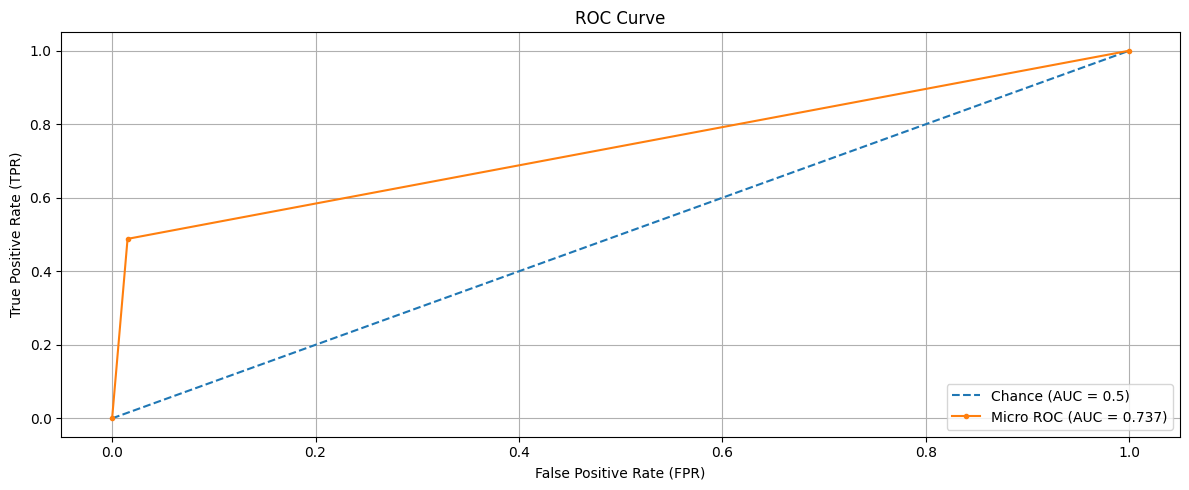

In [12]:
# Check the 
#

fpr_dict, tpr_dict, thr_dict, auc_macro, Y_true, Y_score = eval_obj.roc_deviation_multilabel('macro')
_,        _,         _,       auc_micro, _,      _       = eval_obj.roc_deviation_multilabel('micro')

print("Macro-avg AUC:", auc_macro)
print("Micro-avg AUC:", auc_micro)

# To plot e.g. the “micro” ROC curve as a single line:
fpr_micro, tpr_micro, _ = roc_curve(Y_true.ravel(), Y_score.ravel())

fig, (ax2) = plt.subplots(1, figsize=(12, 5))

# ROC Curves
ax2.plot([0, 1], [0, 1], linestyle='--', label='Chance (AUC = 0.5)')
# micro-averaged ROC
ax2.plot(fpr_micro, tpr_micro, marker='.', label=f'Micro ROC (AUC = {auc_micro:.3f})')

ax2.set_xlabel('False Positive Rate (FPR)')
ax2.set_ylabel('True Positive Rate (TPR)')
ax2.set_title('ROC Curve')
ax2.legend(loc='lower right')
ax2.grid(True)

plt.tight_layout()
plt.show()

Macro-avg AUC: 0.7509420235032956
Micro-avg AUC: 0.7392819050615227


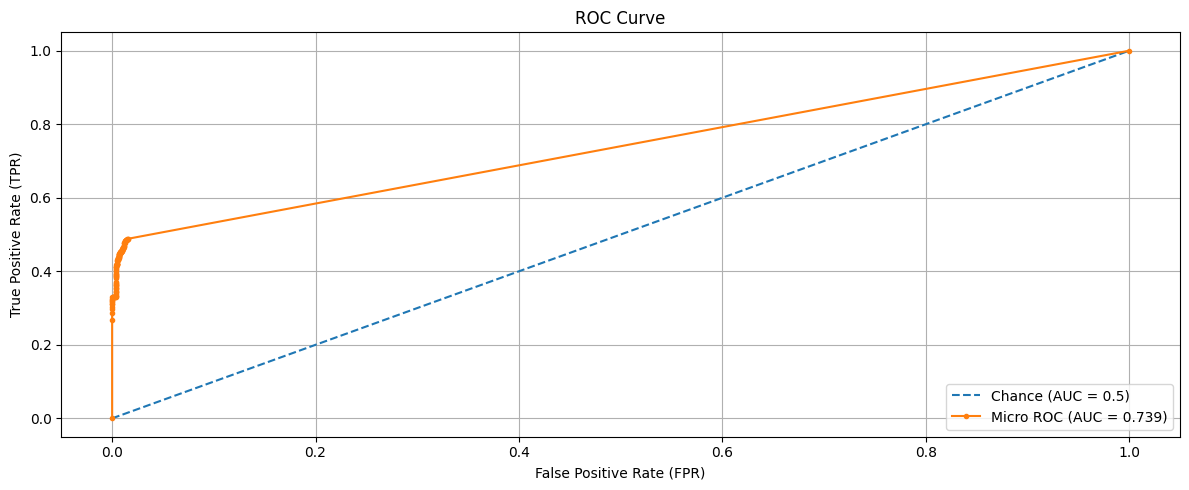

In [13]:
#

fpr_dict, tpr_dict, thr_dict, auc_macro, Y_true, Y_score = eval_obj.probabilistic_roc_deviation_multilabel(deviations_samples_risk=deviations_samples_risk_prob, average='macro')
_,        _,         _,       auc_micro, _,      _       = eval_obj.probabilistic_roc_deviation_multilabel(deviations_samples_risk=deviations_samples_risk_prob, average='micro')

print("Macro-avg AUC:", auc_macro)
print("Micro-avg AUC:", auc_micro)

# To plot e.g. the “micro” ROC curve as a single line:
fpr_micro, tpr_micro, _ = roc_curve(Y_true.ravel(), Y_score.ravel())

fig, (ax2) = plt.subplots(1, figsize=(12, 5))

# 2) ROC Curves
# chance line
ax2.plot([0, 1], [0, 1], linestyle='--', label='Chance (AUC = 0.5)')
# micro-averaged ROC
ax2.plot(fpr_micro, tpr_micro, marker='.', label=f'Micro ROC (AUC = {auc_micro:.3f})')

# ax2.plot(fpr_micro, tpr_micro, marker='.', label=f'Macro ROC (AUC = {auc_macro:.3f})')

ax2.set_xlabel('False Positive Rate (FPR)')
ax2.set_ylabel('True Positive Rate (TPR)')
ax2.set_title('ROC Curve')
ax2.legend(loc='lower right')
ax2.grid(True)

plt.tight_layout()
plt.show()

In [14]:
filename = os.path.join(output_dir, 'all_inference_set.pkl')
with open(filename, 'rb') as f:
    loaded_results_all = pickle.load(f)
print(f"Loaded data from {filename}")

# grab the list of all metric‐names from the first entry
fields_all = list(loaded_results_all[next(iter(loaded_results_all))].keys())

# build the “pivoted” dict of dicts
seperate_dict_all = {field: { prefix: subdict[field] for prefix, subdict in loaded_results_all.items() } for field in fields_all}

Loaded data from ../../../../../../data/Helpdesk/conformal_prediction_gn_l4/all_inference_set.pkl


In [15]:
# Compute retentantion and discarded information rate:

# Retantion rate: How many cases relatively to all cases are kept in the risk set.
cases_risk = np.sum([case_len for case_len in [len(case_ids) for case_ids in seperate_dict_risk['test_case_id'].values()]])

cases_all = np.sum([case_len for case_len in [len(case_ids) for case_ids in seperate_dict_all['test_case_id'].values()]])

retantion_rate = cases_risk / cases_all

print("Risk Set contains", cases_risk, "cases.")

print("All Set contains", cases_all, "cases.")

print("Retention Rate: Risk Set contains", retantion_rate*100, "%", "of the cases, All Cases Set contains.")

Risk Set contains 852 cases.
All Set contains 1946 cases.
Retention Rate: Risk Set contains 43.782117163412124 % of the cases, All Cases Set contains.


In [16]:
filename = os.path.join(output_dir, 'discarded_risk_inference_set.pkl')
with open(filename, 'rb') as f:
    loaded_results_discarded = pickle.load(f)
print(f"Loaded data from {filename}")

# grab the list of all metric‐names from the first entry
fields_discarded = list(loaded_results_discarded[next(iter(loaded_results_discarded))].keys())

# build the “pivoted” dict of dicts
seperate_dict_discarded = {field: { prefix: subdict[field] for prefix, subdict in loaded_results_discarded.items() } for field in fields_discarded}

Loaded data from ../../../../../../data/Helpdesk/conformal_prediction_gn_l4/discarded_risk_inference_set.pkl


In [17]:
# Check how many of the discarded cases contain deviations and contain therefore information that is missed.

cases_discarded = np.sum([case_len for case_len in [len(case_ids) for case_ids in seperate_dict_discarded['test_case_id'].values()]])

target_connformance_discarded = seperate_dict_discarded['target_conformance']

information_discarded = 0
for pref_len, values in seperate_dict_discarded['target_conformance'].items():
    for conf_dicts in values:
        if conf_dicts['fitness'] < 1:
            information_discarded += 1

information_discarded = np.int64(information_discarded)

print("Total amount of discarded cases that contain deviations:", information_discarded)
print("Relative number of discarded cases that contain deviations to all discarded cases:", information_discarded / cases_discarded * 100, "%")
print("Relative number of discarded cases that contain deviations to all cases:", information_discarded / cases_all * 100, "%")

print("\n")

print("Total amount of discarded cases that contain NO devitations:", cases_discarded-information_discarded)
print("Relative number to all discarded cases:", (cases_discarded-information_discarded) / cases_discarded * 100, "%")
print("Relative number of discarded cases that contain NO deviations to all cases:",(cases_discarded-information_discarded) / cases_all * 100, "%")


Total amount of discarded cases that contain deviations: 149
Relative number of discarded cases that contain deviations to all discarded cases: 13.619744058500913 %
Relative number of discarded cases that contain deviations to all cases: 7.656731757451182 %


Total amount of discarded cases that contain NO devitations: 945
Relative number to all discarded cases: 86.38025594149909 %
Relative number of discarded cases that contain NO deviations to all cases: 48.561151079136685 %


In [18]:
print("Risk Set (relatively to all): ", retantion_rate*100, "%", "discarded cases (relateively to all): ", (cases_discarded-information_discarded) / cases_all * 100, "%", "discarded cases containing information/deviations (relateively to all): ", information_discarded / cases_all*100, "%")
print("Sum: ", math.floor(((retantion_rate + information_discarded/cases_all + cases_discarded-information_discarded)/cases_all))+100, "%") 

Risk Set (relatively to all):  43.782117163412124 % discarded cases (relateively to all):  48.561151079136685 % discarded cases containing information/deviations (relateively to all):  7.656731757451182 %
Sum:  100 %
